In [ ]:
# Install kaggle
!pip install -q kaggle

# Buat folder untuk config
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

# Upload file kaggle.json (API key dari akun kamu)
from google.colab import files
files.upload()  # ← pilih kaggle.json di sini

# Unduh dataset dari Kaggle (ukuran sekitar 200MB)
!kaggle datasets download -d d4rklucif3r/cat-and-dogs
!unzip -q cat-and-dogs.zip -d cat_dog_data

# Lihat isi folder
os.listdir("cat_dog_data")


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/d4rklucif3r/cat-and-dogs
License(s): DbCL-1.0
 54% 118M/218M [00:00<00:00, 1.22GB/s]
100% 218M/218M [00:00<00:00, 694MB/s] 


['dataset']

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Path ke dataset
data_dir = "/content/cat_dog_data/dataset/training_set"

# ImageDataGenerator dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

# Resize ke 160x160 untuk MobileNetV2
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(160, 160),
    batch_size=16,
    class_mode="binary",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(160, 160),
    batch_size=16,
    class_mode="binary",
    subset="validation"
)

# Load base model MobileNetV2
base_model = MobileNetV2(input_shape=(160, 160, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze feature extractor

# Model akhir
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3
)


Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Epoch 1/3
400/400 ━━━━━━━━━━━━━━━━━━━━ 188s 456ms/step - accuracy: 0.8519 - loss: 0.3001 - val_accuracy: 0.9519 - val_loss: 0.1137
Epoch 2/3
400/400 ━━━━━━━━━━━━━━━━━━━━ 183s 459ms/step - accuracy: 0.9470 - loss: 0.1327 - val_accuracy: 0.9644 - val_loss: 0.0934
Epoch 3/3
400/400 ━━━━━━━━━━━━━━━━━━━━ 181s 453ms/step - accuracy: 0.9529 - loss: 0.1098 - val_accuracy: 0.9600 - val_loss: 0.1036


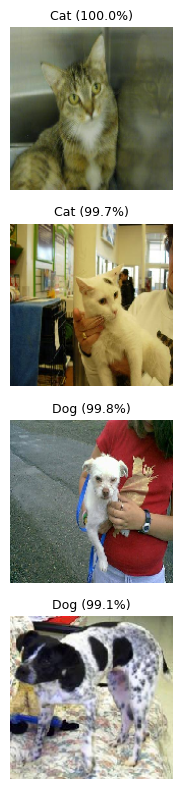

File disimpan di: /content/prediction_1x4_vertical_fit.jpg


In [7]:
import os
from glob import glob
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Path ke test set
test_dir = "/content/cat_dog_data/dataset/test_set"
img_size = (160, 160)

# Ambil 2 gambar kucing + 2 gambar anjing
cat_images = glob(os.path.join(test_dir, "cats/*.jpg"))
dog_images = glob(os.path.join(test_dir, "dogs/*.jpg"))
test_images = cat_images[:2] + dog_images[:2]

# Ukuran lebih fit: 1 kolom × 4 baris, lebar sempit
fig, axes = plt.subplots(4, 1, figsize=(2, 8))  # Lebih ramping & pas
axes = axes.flatten()

for idx, img_path in enumerate(test_images):
    # Load & preprocess
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Prediksi
    pred = model.predict(img_array, verbose=0)[0][0]
    label = "Dog" if pred >= 0.5 else "Cat"
    conf = pred if pred >= 0.5 else 1 - pred

    # Tampilkan
    ax = axes[idx]
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"{label} ({conf*100:.1f}%)", fontsize=9)

    # # Bounding box (mengelilingi seluruh gambar)
    # rect = patches.Rectangle((0, 0), img_size[0], img_size[1],
    #                          linewidth=2, edgecolor='lime', facecolor='none')
    # ax.add_patch(rect)

# Simpan sebagai file
plt.tight_layout()
output_path = "/content/prediction_1x4_vertical_fit.jpg"
plt.savefig(output_path, dpi=120)
plt.show()

print(f"File disimpan di: {output_path}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Ambil data
epochs = range(len(history.history['accuracy']))
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Interpolasi spline
epochs_smooth = np.linspace(min(epochs), max(epochs), 300)

train_acc_smooth = make_interp_spline(epochs, train_acc)(epochs_smooth)
val_acc_smooth = make_interp_spline(epochs, val_acc)(epochs_smooth)
train_loss_smooth = make_interp_spline(epochs, train_loss)(epochs_smooth)
val_loss_smooth = make_interp_spline(epochs, val_loss)(epochs_smooth)

# Plot Akurasi
plt.figure(figsize=(6, 4))
plt.plot(epochs_smooth, train_acc_smooth, label='Train Accuracy', color='blue')
plt.plot(epochs_smooth, val_acc_smooth, label='Val Accuracy', color='orange')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
output_path = "/content/Accuracy & Train.jpg"
plt.savefig(output_path, dpi=120)
plt.show()




In [ ]:
# Plot Loss
plt.figure(figsize=(6, 4))
plt.plot(epochs_smooth, train_loss_smooth, label='Train Loss', color='green')
plt.plot(epochs_smooth, val_loss_smooth, label='Val Loss', color='red')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
output_path = "/content/Loss & val_loss.jpg"
plt.savefig(output_path, dpi=120)
plt.show()

In [ ]:
import os
from glob import glob
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Path test set
test_dir = "/content/cat_dog_data/dataset/test_set"
img_size = (160, 160)

# Ambil sample data
cat_images = glob(os.path.join(test_dir, "cats/*.jpg"))[:5]
dog_images = glob(os.path.join(test_dir, "dogs/*.jpg"))[:5]
test_images = cat_images + dog_images

# Ambil label asli
actual_labels = [0]*5 + [1]*5  # 0 = Cat, 1 = Dog

# Prediksi model
predicted_labels = []
confidences = []

for img_path in test_images:
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    pred = model.predict(img_array, verbose=0)[0][0]
    predicted_labels.append(1 if pred >= 0.5 else 0)
    confidences.append(pred if pred >= 0.5 else 1 - pred)

# Buat bar chart
x = np.arange(len(test_images))
width = 0.35

plt.figure(figsize=(8, 4))
plt.bar(x - width/2, actual_labels, width, label='Actual', color='gray')
plt.bar(x + width/2, predicted_labels, width, label='Predicted', color='blue')
plt.xticks(x, [f'Img {i+1}' for i in x])
plt.ylim(0, 1.2)
plt.ylabel('Class')
plt.title('Actual vs Predicted (0=Cat, 1=Dog)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
